# Tutorial 6: FEM for a jacket wind turbine
In this tutorial we will use the FEM to solve a simplified jacket wind turbine. We assume that the structure can be modelled as a space frame with structural elements that are subject to axial discplacement and bending. Therefore, the equations of motion at a given element are given by:

$$ \rho A \frac{\partial^2 u (x,t)}{\partial t^2} - E A \frac{\partial^2 u(x,t)}{\partial x^2} = q_u(x) $$

$$ \rho A \frac{\partial^2 v (x,t)}{\partial t^2} + E I \frac{\partial^4 v(x,t)}{\partial x^4} = q_v(x) $$

In the following figure we have a sketch of the simplified geometry that will be used in this example.

![figure](tutorial8_figure.png)

Let's start by initializing the script and setting some parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scp

# Input parameters
# Nacelle
Mass_Nacelle = 5000             # [kg]

# Pile
m_Pile = 1000                   # [kg/m]
EI_Pile = 1e9                   # [N.m2]
EA_Pile = 1e8                   # [N]
H_Pile = 100                    # [m]

# Jacket
m_Jacket = 100                  # [kg/m]
EI_Jacket = 1e7                 # [N.m2]
EA_Jacket = 1e6                 # [N]
H_Jacket = 70                   # [m]
Base_Jacket = 30.23             # [m]
Top_Jacket = 16.13              # [m]

# Define load parameters
f0 = 2                          # [Hz]
A0 = 0.1                        # [m]
T0 = 20                         # [s]

# Define output time vector
dt = 0.01                       # [s]
T = np.arange(0, 5*T0, dt)
nT = len(T)

## Step 1: discretize the domain
As usual, we start by discretizing the domain. We will discretize the structure using 21 nodes, as depicted in the following figure.

![figure2](tutorial8_figure2.png)

Here we first define a matrix with the nodal coordinates.

In [2]:
# Define node coordinates
NodeCoord = ([-(Base_Jacket*4+Top_Jacket*0)/4/2,      -4*H_Jacket/4],  # Point 1
              [(Base_Jacket*4+Top_Jacket*0)/4/2,      -4*H_Jacket/4],  # Point 2
             [-(Base_Jacket*3+Top_Jacket*1)/4/2,      -3*H_Jacket/4],  # Point 3
              [(Base_Jacket*3+Top_Jacket*1)/4/2,      -3*H_Jacket/4],  # Point 4
             [-(Base_Jacket*2+Top_Jacket*2)/4/2,      -2*H_Jacket/4],  # Point 5
              [(Base_Jacket*2+Top_Jacket*2)/4/2,      -2*H_Jacket/4],  # Point 6
             [-(Base_Jacket*1+Top_Jacket*3)/4/2,      -1*H_Jacket/4],  # Point 7
              [(Base_Jacket*1+Top_Jacket*3)/4/2,      -1*H_Jacket/4],  # Point 8
             [-(Base_Jacket*0+Top_Jacket*4)/4/2,       0*H_Jacket/4],  # Point 9
                                             [0,       0*H_Jacket/4],  # Point 10
              [(Base_Jacket*0+Top_Jacket*4)/4/2,       0*H_Jacket/4],  # Point 11
                                             [0,                 10],  # Point 12
                                             [0,                 20],  # Point 13
                                             [0,                 30],  # Point 14
                                             [0,                 40],  # Point 15
                                             [0,                 50],  # Point 16
                                             [0,                 60],  # Point 17
                                             [0,                 70],  # Point 18
                                             [0,                 80],  # Point 19
                                             [0,                 90],  # Point 20
                                             [0,                100])  # Point 21
nNode = len(NodeCoord)

Once we have the node coordinates we proceed to define the elemental connectivities. Here, we will use the same array to assign the material  properties to each element. Note that they are different depending on which part of the structure they belong to.

In [3]:
# Define elements (and their properties
#             NodeLeft    NodeRight          m         EA        EI
Elements = (         [1,            3,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [1,            4,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [2,            4,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [3,            4,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [3,            5,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [5,            4,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [4,            6,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [5,            6,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [5,            7,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [5,            8,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [6,            8,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [7,            8,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [7,            9,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [9,            8,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [8,           11,   m_Jacket,  EA_Jacket, EI_Jacket],
                     [9,           10,   m_Jacket,  EA_Jacket, EI_Jacket],
                    [10,           11,   m_Jacket,  EA_Jacket, EI_Jacket],
                    [10,           12,   m_Pile,    EA_Pile,   EI_Pile],
                    [12,           13,   m_Pile,    EA_Pile,   EI_Pile],
                    [13,           14,   m_Pile,    EA_Pile,   EI_Pile],
                    [14,           15,   m_Pile,    EA_Pile,   EI_Pile],
                    [15,           16,   m_Pile,    EA_Pile,   EI_Pile],
                    [16,           17,   m_Pile,    EA_Pile,   EI_Pile],
                    [17,           18,   m_Pile,    EA_Pile,   EI_Pile],
                    [18,           19,   m_Pile,    EA_Pile,   EI_Pile],
                    [19,           20,   m_Pile,    EA_Pile,   EI_Pile],
                    [20,           21,   m_Pile,    EA_Pile,   EI_Pile])
nElem = len(Elements)

Let's plot the structure to make sure that it looks like the model in the figure.

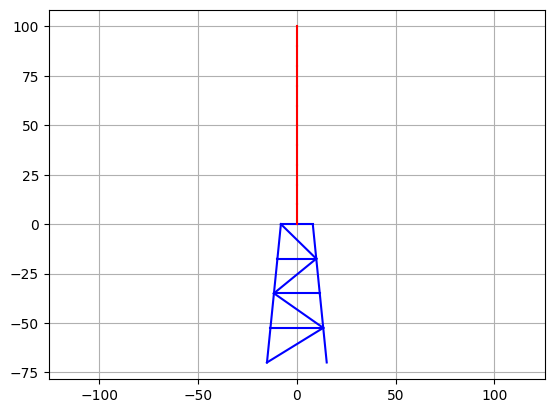

In [4]:
plt.figure()
for iElem in np.arange(0, nElem):
    NodeLeft = Elements[iElem][0]-1
    NodeRight = Elements[iElem][1]-1
    m = Elements[iElem][2]
    EA = Elements[iElem][3]
    EI = Elements[iElem][4]
    if m == m_Jacket and EA == EA_Jacket and EI == EI_Jacket:
        c = 'b'
    elif m == m_Pile and EA == EA_Pile and EI == EI_Pile:
        c = 'r'
    else:
        print("ERROR: unknown material. Check your inputs.")
        break
    plt.plot([NodeCoord[NodeLeft][0], NodeCoord[NodeRight][0]], [NodeCoord[NodeLeft][1], NodeCoord[NodeRight][1]], c=c)
plt.axis('equal')
plt.grid()

## Step 2: define the shape functions

Here we will use the exact same functions as in tutorial 4 and 5. Linear shape functions for the axial displacement and cubic shape functions for the deflection and rotations. Since we already know its expression and we already have the value of the elemental matrices, we skip this step in this tutorial. 

## Step 3: computation of the elemental matrices

In the theory we have seen that the mass and stiffness elemental matrices for the space frame using linear and cubic shape functions are given by:

$$ \bold{M} = \frac{mL}{420} \begin{bmatrix} 140 & 0 & 0 & 70 & 0 & 0 \\ 0 & 156 & 22L & 0 & 54 & -13L \\ 0 & 22L & 4L^2 & 0 & 13L & -3L^2 \\ 70 & 0 & 0 & 140 & 0 & 0 \\ 0 & 54 & 13L & 0 & 156 & -22L \\ 0 & -13L & -3L^2 & 0 & -22L & 4L^2 \end{bmatrix} $$
$$ \quad \bold{K} = \begin{bmatrix} \frac{EA}{L} & 0 & 0 & \frac{-EA}{L} &  0 & 0 \\ 0 & \frac{12EI}{L^3} & \frac{6EI}{L^2} & 0 & \frac{-12EI}{L^3} & \frac{6EI}{L^2} \\ 0 & \frac{6EI}{L^2} & \frac{4EI}{L} & 0 & \frac{-6EI}{L^2} & \frac{2EI}{L} \\ \frac{-EA}{L} & 0 & 0 & \frac{EA}{L} & 0 & 0 \\ 0 & \frac{-12EI}{L^3} & \frac{-6EI}{L^2} & 0 & \frac{12EI}{L^3} & \frac{-6EI}{L^2} \\ 0 & \frac{6EI}{L^2} & \frac{2EI}{L} & 0 & \frac{-6EI}{L^2} & \frac{4EI}{L} \end{bmatrix}$$

These matrices are used directly when calling the `BeamMatrices` function within the assembly process.

## Step 4: global assembly

The last step is to compute the global matrices and the global forcing vector. We start by initializing the global matrices as 1-dimensional arrays.

In [5]:
nDof = 3*nNode              # 3 Degrees of freedom per node
K = np.zeros((nDof*nDof))
M = np.zeros((nDof*nDof))

Then we loop over elements and perform all the elemental operations.

In [6]:
from module_imports.BeamMatrices import BeamMatricesJacket
for iElem in np.arange(0, nElem):
    # Get the nodes of the elements
    NodeLeft = Elements[iElem][0]-1
    NodeRight = Elements[iElem][1]-1
    
    # Get the degrees of freedom that correspond to each node
    Dofs_Left = 3*(NodeLeft) + np.arange(0, 3)
    Dofs_Right = 3*(NodeRight) + np.arange(0, 3)

    # Get the properties of the element
    m = Elements[iElem][2]
    EA = Elements[iElem][3]
    EI = Elements[iElem][4]

    # Calculate the matrices of the element
    Me, Ke = BeamMatricesJacket(m, EA, EI, ([NodeCoord[NodeLeft][0], NodeCoord[NodeLeft][1]], [NodeCoord[NodeRight][0], NodeCoord[NodeRight][1]]))

    # Assemble the matrices at the correct place
    nodes = np.append(Dofs_Left, Dofs_Right)
    for i in np.arange(0, 6):
        for j in np.arange(0, 6):
            ij = nodes[j] + nodes[i]*nDof
            #print(ij)
            M[ij] = M[ij] + Me[i, j]
            K[ij] = K[ij] + Ke[i, j]
            
# Reshape the global matrix from a 1-dimensional array to a 2-dimensional array
M = M.reshape((nDof, nDof))
K = K.reshape((nDof, nDof))

Now we have the global mass and stiffness matrices. However, in this example we have an additional point mass at the top corresponding to the nacelle. Then, we need to account for this mass adding its value at the corresponding DOFs, in this case the corresponding horizontal and vertical displacements associated to the top node.

In [7]:
nacelle_node = nNode
nacelle_dof_h = 3*(nacelle_node-1)
nacelle_dof_v = 3*(nacelle_node-1)+1
M[nacelle_dof_h, nacelle_dof_h] += Mass_Nacelle
M[nacelle_dof_v, nacelle_dof_v] += Mass_Nacelle

That completes the filling of the matrices. Let's have a look at the matrices' structure.

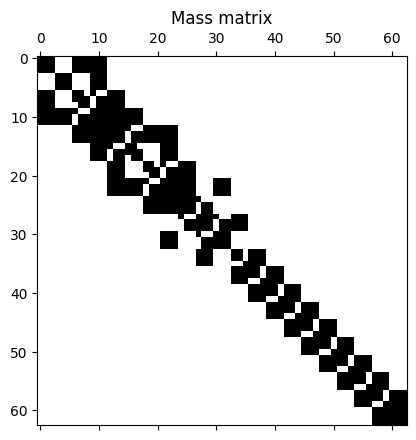

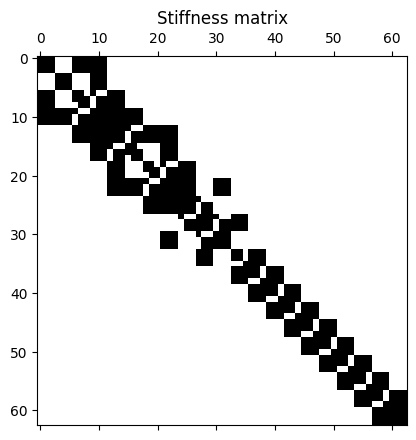

In [8]:
# Look at the matrix structure
plt.figure()
plt.spy(M)
plt.title("Mass matrix")
plt.figure()
plt.spy(K)
plt.title("Stiffness matrix");

To apply the boundary conditions, we will remove the rows associated to the fixed DOFs and add the contribution to the right-hand-side. First, we obtain the free and fixed DOFs.

In [9]:
DofsP = np.arange(0, 6)          # prescribed DOFs
DofsF = np.arange(0, nDof)       # free DOFs
DofsF = np.delete(DofsF, DofsP)  # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = DofsF[:, np.newaxis]
fy = DofsF[np.newaxis, :]
bx = DofsP[:, np.newaxis]
by = DofsP[np.newaxis, :]

We can re-order the matrices and vectors in blocks, such that it's easy to operate with the blocks corresponding with the fixed DOFs.

In [10]:
# Mass
M_FF = M[fx, fy]
M_FP = M[fx, by]
M_PF = M[bx, fy]
M_PP = M[bx, by]

# Stiffness
K_FF = K[fx, fy]
K_FP = K[fx, by]
K_PF = K[bx, fy]
K_PP = K[bx, by]

## Step 5: modal analysis

Using the matrices associated to the free DOFs, we can perform a modal analysis to get more information on how the structure will deform and determine the natural frequencies.

$$ ( \bold{K}_{FF} - \omega^2 \bold{M}_{FF} ) \bold{\phi} = \bold{0} $$

To compute the natural frequencies and mode shapes we use the `eig` command, which is part of the NumPy package. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

In [11]:
mat = np.dot(np.linalg.inv(M_FF), K_FF)
w2, vr = np.linalg.eig(mat)
w = np.sqrt(w2.real)
f = w/2/np.pi

We sort the frequencies and mode shapes in descending order:

In [12]:
idx = f.argsort()[::1]  
f = f[idx]
ModalShape = np.zeros((nDof, len(f)))
ModalShape[6:, :] = vr[:, idx]

Let's see what these modes look like. Here, we plot the first 9 modes. Note that the system will have 19 x 3 = 57 modes (as many as the discrete system DOFs).

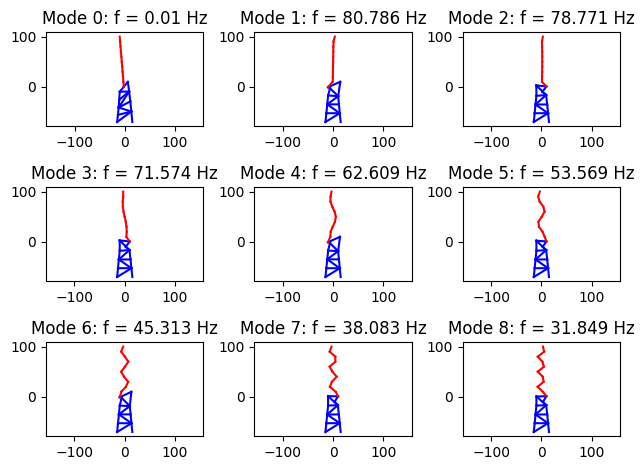

In [13]:
nMode = 9
plt.figure()
nCol = int(np.round(np.sqrt(nMode)))
nRow = int(np.ceil(nMode/nCol))
for iMode in np.arange(0, nMode):
    plt.subplot(nRow, nCol, iMode+1)
    Shape = ModalShape[:, -iMode]

    # Scale the mode such that maximum deformation is 10
    MaxTranslationx = np.max(np.abs(Shape[0::3]))
    MaxTranslationy = np.max(np.abs(Shape[1::3]))
    Shape[0::3] = Shape[0::3]/MaxTranslationx*10
    Shape[1::3] = Shape[1::3]/MaxTranslationy*10

    # Get the deformed shape
    DisplacedNode = ([i[0] for i in NodeCoord] + Shape[0::3], [i[1] for i in NodeCoord] + Shape[1::3])
    for iElem in np.arange(0, nElem):
        NodeLeft = Elements[iElem][0]-1
        NodeRight = Elements[iElem][1]-1
        m = Elements[iElem][2]
        EA = Elements[iElem][3]
        EI = Elements[iElem][4]
        if m == m_Jacket and EA == EA_Jacket and EI == EI_Jacket:
            c = 'b'
        elif m == m_Pile and EA == EA_Pile and EI == EI_Pile:
            c = 'r'
        else:
            print("ERROR: unknown material. Check your inputs.")
            break
        plt.plot([DisplacedNode[0][NodeLeft], DisplacedNode[0][NodeRight]], 
                    [DisplacedNode[1][NodeLeft], DisplacedNode[1][NodeRight]], c=c)
    plt.title("Mode "+str(iMode)+": f = "+str(round(f[-iMode],3))+" Hz")
    plt.axis('equal')

# automatically fix subplot spacing
plt.tight_layout()

## Step 5: solving the ODE

We can also solve the final ODE. In this example we assume that we don't have an external force and the system is excited by the effect of an earthquak, modelled with the following horizontal motion at the boundary nodes:

$$ u_P = A_0 sin (2\pi f_0t) $$

$$ u'_P = 2 \pi f_0 A_0 cos(2\pi f_0t) $$

$$ u''_P = - (2 \pi f_0)^2 A_0 sin(2\pi f_0t) $$

In [14]:
# Set Dimensions and initial conditions of state vector
nDofsF = len(DofsF)
udofs = np.arange(0, nDofsF)
vdofs = np.arange(nDofsF, 2*nDofsF)
q0 = np.zeros((2*nDofsF))

# Define the boundary conditions
def ub(t, T0):
    if t <= T0:
        return A0*np.sin(2*np.pi*f0*t)*np.array([1, 0, 0, 1, 0, 0])
    else:
        return np.array([0, 0, 0, 0, 0, 0])
def dub_dt2(t, T0):
    return -(2*np.pi*f0)**2*ub(t, T0)

# Time span (output purposes)
tf = 2 #50
tspan = np.arange(0, tf, 0.01)

# Solve
def odefun(t, q):
    print(t)
    return np.append(q[vdofs], np.linalg.solve(M_FF, -np.dot(K_FP, ub(t, T0)) - 
            np.dot(M_FP, dub_dt2(t, T0)) - np.dot(K_FF, q[udofs]))).tolist()

sol = scp.solve_ivp(fun=odefun, t_span=[tspan[0], tspan[-1]], y0=q0, t_eval=tspan)  

0.0
1e-06
1.9999999999999998e-05
2.9999999999999997e-05
7.999999999999999e-05
8.888888888888888e-05
9.999999999999999e-05
9.999999999999999e-05
0.00030000000000000003
0.00039999999999999996
0.0009
0.0009888888888888888
0.0011
0.0011
0.0031000000000000003
0.0041
0.0091
0.00998888888888889
0.0111
0.0111
0.01298923951931938
0.01393385927897907
0.01865695807727752
0.019496620085863912
0.0205461975965969
0.0205461975965969
0.012245288825002901
0.012817933237504351
0.0156811553000116
0.016190172555568445
0.0168264441250145
0.0168264441250145
0.017971732950017402
0.018544377362518853
0.021407599425026104
0.021916616680582948
0.022552888250029005
0.022552888250029005
0.023708362396147098
0.024286099469206145
0.027174784834501378
0.027688328899442755
0.02833025898061947
0.02833025898061947
0.02946324210897702
0.030029733673155794
0.03286219149404966
0.033365739551097465
0.03399517462240721
0.03399517462240721
0.03516312720511418
0.035747103496467654
0.03866698495323506
0.03918607498999371
0.039

0.2582926535790409
0.258666713525242
0.2605370132562476
0.2608695109862042
0.2612851331486499
0.2612851331486499
0.26196870994026356
0.26231049833607034
0.2640194403151045
0.26432325222248837
0.2647030171067182
0.2647030171067182
0.2657423061194875
0.2662619506258722
0.2688601731577956
0.2693220793856931
0.26989946217056493
0.26989946217056493
0.2653632613427585
0.26569338346077864
0.2673439940508794
0.267637435933564
0.2680042382869197
0.2680042382869197
0.26866448252296005
0.2689946046409802
0.2706452152310809
0.2709386571137655
0.27130545946712126
0.27130545946712126
0.272169282798243
0.2726011944638038
0.27476075279160805
0.2751446742721066
0.2756245761227298
0.2756245761227298
0.271974828276091
0.2723095126805758
0.27398293470300006
0.27428043195143104
0.2746523035119698
0.2746523035119698
0.2753216723209395
0.2756563567254243
0.2773297787478486
0.27762727599627957
0.2779991475568183
0.2779991475568183
0.27878096167767574
0.27917186873810446
0.2811264040402481
0.28147387698285137


0.4796785776824532
0.48042879124725074
0.48080389802964957
0.4826794319416435
0.4830128601926646
0.483429645506441
0.483429645506441
0.4803432100152035
0.48067552618157866
0.4823371070134544
0.48263249916134343
0.4830017393462047
0.4830017393462047
0.4836653610051484
0.48399717183462027
0.48565622598197955
0.4859511689415101
0.48631984764092323
0.48631984764092323
0.48716089510878513
0.48758141884271605
0.4896840375123708
0.4900578363869761
0.4905250849802327
0.4905250849802327
0.4869809987134241
0.4873115742496745
0.4889644519309266
0.4892582968520381
0.48962560300342745
0.48962560300342745
0.4902867540759283
0.4906173296121787
0.4922702072934308
0.4925640522145423
0.49293135836593166
0.49293135836593166
0.4937880296891211
0.49421636535071584
0.4963580436586895
0.49673878646899594
0.49721471498187897
0.49721471498187897
0.49359509572817917
0.49392696440930295
0.4955863078149217
0.4958813021981428
0.4962500451771692
0.4962500451771692
0.4969137825394167
0.49724565122054043
0.4989049946

0.6678338355257962
0.6681541813161662
0.6697559102680161
0.6700406620816782
0.6703966018487559
0.6703966018487559
0.6711086763693642
0.6714647136296683
0.6732448999311891
0.6735613774959038
0.6739569744517974
0.6739569744517974
0.671017175893898
0.6713274629164689
0.672878898029324
0.6731547087160538
0.673499472074466
0.673499472074466
0.6741184870088623
0.6744279944760604
0.6759755318120511
0.6762506495606717
0.6765945467464474
0.6765945467464474
0.6773509539266077
0.6777291575166878
0.6796201754670885
0.6799563564360487
0.6803765826472489
0.6803765826472489
0.6772404199010518
0.677563356478354
0.6791780393648651
0.6794650941002448
0.6798239125194695
0.6798239125194695
0.6804697856740739
0.6807927222513761
0.6824074051378872
0.6826944598732669
0.6830532782924916
0.6830532782924916
0.683857852392081
0.6842601394418757
0.686271574690849
0.6866291631795554
0.6870761487904383
0.6870761487904383
0.683685812602788
0.6840020797579363
0.6855834155336774
0.6858645418938092
0.6862159498439738
0

0.8572869182312648
0.857687415520014
0.8596899019637604
0.8600458995537597
0.8604908965412589
0.8604908965412589
0.8571479385246116
0.8574789459600343
0.8591339831371475
0.8594282119686343
0.8597959980079928
0.8597959980079928
0.860458012878838
0.8607890203142607
0.862444057491374
0.8627382863228608
0.8631060723622193
0.8631060723622193
0.8639043995255992
0.8643035631072892
0.866299381015739
0.8666541930883522
0.8670977081791189
0.8670977081791189
0.8637497428921052
0.8640715781570482
0.865680754481763
0.8659668302728234
0.8663244250116489
0.8663244250116489
0.8669680955415348
0.8672899308064778
0.8688991071311926
0.869185182922253
0.8695427776610785
0.8695427776610785
0.8702723285704531
0.8706371040251404
0.872460981298577
0.8727852261471879
0.8731905322079516
0.8731905322079516
0.8701979734497464
0.8705255713440803
0.87216356081575
0.8724547589440468
0.8728187566044179
0.8728187566044179
0.8734739523930858
0.8738015502874197
0.8754395397590894
0.8757307378873862
0.8760947355477573
0.

1.044326920712963
1.044326920712963
1.044907004913801
1.04519704701422
1.0466472575163146
1.046905072716687
1.0472273417171525
1.0472273417171525
1.0481434686755164
1.0486015321546984
1.050891849550608
1.0512990170876588
1.051807976508972
1.051807976508972
1.0478508341927857
1.0481625804306025
1.0497213116196857
1.0499984193866339
1.050344804095319
1.050344804095319
1.0509682965709521
1.051280042808769
1.0528387739978522
1.0531158817648003
1.0534622664734854
1.0534622664734854
1.0543215666822057
1.054751216786566
1.056899467308367
1.0572813785122426
1.0577587675170872
1.0577587675170872
1.0540586059117032
1.054356775630812
1.0558476242263564
1.0561126639766754
1.0564439636645742
1.0564439636645742
1.0570299654513078
1.0573229663446746
1.0587879708115084
1.0590484160500568
1.059373972598242
1.059373972598242
1.0602115601621362
1.0606303539440833
1.0627243228538188
1.0630965839933273
1.063561910417713
1.063561910417713
1.0600018795166855
1.060315832975907
1.0618856002720154
1.06216467001

1.2213966679171755
1.2213966679171755
1.2221520528344876
1.2225297452931436
1.224418207586424
1.2247539342163405
1.2251735925037361
1.2251735925037361
1.2258678341056426
1.226214954906596
1.2279505589113622
1.2282591107344316
1.2286448005132686
1.2286448005132686
1.229308628060078
1.2296405418334826
1.231300110700506
1.2315951451657545
1.2319639382473153
1.2319639382473153
1.2328036798927826
1.2332235507155163
1.2353229048291843
1.2356961233382808
1.2361626464746516
1.2361626464746516
1.2326108335558053
1.23293428121005
1.2345515194812748
1.2348390285072703
1.2351984147897648
1.2351984147897648
1.2358453100982547
1.2361687577524996
1.2377859960237243
1.2380735050497198
1.2384328913322142
1.2384328913322142
1.2394251224816135
1.2399212380563132
1.2424018159298114
1.2428428075517666
1.2433940470792106
1.2433940470792106
1.23906812765516
1.239385745816633
1.240973836623998
1.2412561638786406
1.2416090729469438
1.2416090729469438
1.2422331837826248
1.2425452392004654
1.2441055162896681
1.2

1.3823607455222227
1.3826188863756705
1.3829415624424801
1.3829415624424801
1.3835089589717626
1.383792657236404
1.3852111485596106
1.3854633247948471
1.385778545088893
1.385778545088893
1.3865123376781374
1.3868792339727596
1.3887137154458706
1.3890398454855348
1.389447508035115
1.389447508035115
1.3863906736597504
1.3866967379451791
1.3882270593723227
1.3884991165149259
1.38883918794318
1.38883918794318
1.3894479967487465
1.3897524011515299
1.3912744231654461
1.391545004856809
1.3918832319710126
1.3918832319710126
1.3925138574154814
1.3928291701377158
1.394405733748888
1.3946860117242075
1.3950363591933568
1.3950363591933568
1.395652444383104
1.3959604869779774
1.3975006999523452
1.3977745155922328
1.3981167851420924
1.3981167851420924
1.3988106237452118
1.3991575430467715
1.40089213955457
1.4012005122670674
1.4015859781576894
1.4015859781576894
1.3987265638338884
1.3990314531797865
1.4005558999092769
1.400826912661186
1.4011656786010729
1.4011656786010729
1.4017715285862142
1.402074

1.5673937863768985
1.5679715278426234
1.568260398575486
1.5697047522397982
1.5699615262245648
1.570282493705523
1.570282493705523
1.5708483929894264
1.571131342631378
1.5725460908411364
1.5727976016339822
1.5731119901250397
1.5731119901250397
1.5737148640091894
1.5740163009512644
1.575523485661639
1.5757914296101498
1.5761263595457886
1.5761263595457886
1.5766725283259428
1.57694561271602
1.5783110346664055
1.578553776346474
1.5788572034465598
1.5788572034465598
1.5794523711852757
1.5797499550546337
1.5812378744014237
1.5815023933964085
1.5818330421401396
1.5818330421401396
1.5823853662037144
1.5826615282355017
1.5840423383944384
1.5842878157560272
1.5845946624580132
1.5845946624580132
1.5852141536874653
1.5855238993021914
1.5870726273758216
1.5873479568111337
1.5876921186052737
1.5876921186052737
1.5850593726660667
1.5852917277700935
1.5864535032902276
1.5866600411604737
1.586918213498281
1.586918213498281
1.5873829237063346
1.5876152788103615
1.5887770543304955
1.5889835922007416
1.5

1.7552571641182861
1.7555267790876123
1.75586379779927
1.75586379779927
1.756559804653057
1.7569078080799507
1.7586478252144186
1.7589571615938795
1.7593438320682058
1.7593438320682058
1.7564768400475248
1.7567833611716523
1.7583159667922896
1.7585884300137362
1.7589290090405445
1.7589290090405445
1.7595410835204515
1.7598471207604052
1.7613773069601728
1.7616493400623536
1.7619893814400798
1.7619893814400798
1.762665193255254
1.7630030991628411
1.7646926287007767
1.7649929895075207
1.7653684405159509
1.7653684405159509
1.7660014135705562
1.7663179000978586
1.7679003327343716
1.7681816540919741
1.768533305788977
1.768533305788977
1.7692591140560083
1.769622018189524
1.771436538857102
1.771759120309116
1.7721623471241335
1.7721623471241335
1.7691086772534923
1.76939636298575
1.7708347916470386
1.7710905122979343
1.771410163111554
1.771410163111554
1.7719855345760693
1.7722732203083271
1.7737116489696156
1.7739673696205114
1.774287020434131
1.774287020434131
1.774958810371672
1.775294705

1.9261975064021406
1.9265199132826047
1.9265199132826047
1.9270884359326563
1.9273726972576821
1.928794003882811
1.9290466806161672
1.9293625265328627
1.9293625265328627
1.930166453882073
1.9305684175566782
1.9325782359297041
1.9329355369737977
1.9333821632789145
1.9333821632789145
1.9299854401751457
1.9302968969962873
1.9318541811019951
1.9321310316096765
1.9324770947442782
1.9324770947442782
1.9331000083865613
1.9334114652077028
1.9349687493134107
1.935245599821092
1.9355916629556937
1.9355916629556937
1.9363944376117623
1.9367958249397967
1.9388027615799683
1.9391595503159988
1.939605536236037
1.939605536236037
1.9362125742518632
1.936523029899948
1.9380753081403719
1.9383512687164473
1.9386962194365414
1.9386962194365414
1.9393078561457073
1.9396136745002903
1.9411427662732053
1.9414146048106125
1.9417544029823712
1.9417544029823712
1.9425710852600624
1.942979426398908
1.9450211320931357
1.9453841019943316
1.9458378143708268
1.9458378143708268
1.9424007431447328
1.9427239132259135


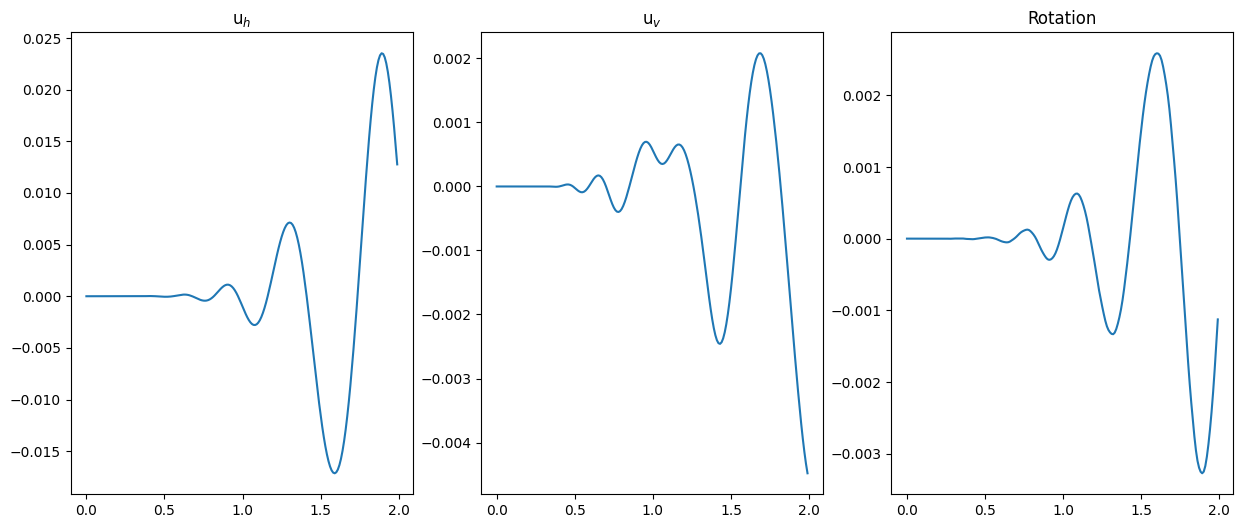

In [15]:
# Plot results
u_total = np.zeros((len(tspan), nDof))
u_total[:, DofsF[0]:DofsF[-1]+1] = np.transpose(sol.y[udofs[0]:udofs[-1]+1, :])
for it in np.arange(0, len(tspan)):
    u_total[it, DofsP] = ub(tspan[it], T0)
nacelle_result = u_total[:, 60:63]

fig, axs = plt.subplots(1, 3, figsize = (15, 6))
axs[0].plot(sol.t, nacelle_result[:, 0])
axs[0].set_title("u$_h$")
axs[1].plot(sol.t, nacelle_result[:, 1])
axs[1].set_title("u$_v$")
axs[2].plot(sol.t, nacelle_result[:, 2])
axs[2].set_title("Rotation");